# JQA Coreference Network -- Analysis

In [1]:
import re, json
import pandas as pd
import numpy as np
import itertools as iter
import networkx as nx
from networkx.algorithms import community
from networkx.readwrite import json_graph
from json import JSONEncoder
from operator import itemgetter
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
    
# Declare directory location to shorten filepaths later.
abs_dir = "/Users/quinn.wi/Documents/"

## Import Data

In [2]:
%%time

with open(abs_dir + 'Data/Output/Graphs/JQA_Network_correlation/coRef-network.json') as rf:
    G = json_graph.node_link_graph( json.load(rf) )
    
print (nx.info(G))

Name: 
Type: Graph
Number of nodes: 5135
Number of edges: 177371
Average degree:  69.0832
CPU times: user 423 ms, sys: 36.3 ms, total: 460 ms
Wall time: 465 ms


## Network Overview

In [3]:
%%time

# Measure network density.
density = nx.density(G)
print (f"Network density: {density:.3f}")

# Related to diameter, check if network is connected and, therefore, can have a diameter.
print (f"Is the network connected? {nx.is_connected(G)}")

# Get a list of network components (communities).
# Find the largest component.
components = nx.connected_components(G)
largest_component = max(components, key = len)

# Create a subgraph of the largest component and measure its diameter.
subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print (f"Network diameter of the largest component: {diameter:.3f}")

# Find triadic closure (similar to density).
triadic_closure = nx.transitivity(G)
print (f"Triadic closure: {triadic_closure:.3f}\n")

# Find centrality measures.
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
degree_cent_dict = nx.degree_centrality(G)

# Assign each centrality measure to an attribute.
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')
nx.set_node_attributes(G, degree_cent_dict, 'degree_cent')


# Find communities.
communities = community.greedy_modularity_communities(G)

# Create a dictionary that maps nodes to their community.
modularity_dict = {}
for i, c in enumerate(communities):
    for name in c:
        modularity_dict[name] = i
        
# Add modularity information to graph object.
nx.set_node_attributes(G, modularity_dict, 'modularity')

Network density: 0.013
Is the network connected? False
Network diameter of the largest component: 5.000
Triadic closure: 0.202

CPU times: user 29min 8s, sys: 6.5 s, total: 29min 15s
Wall time: 29min 37s


### Save Network

In [69]:
%%time

# Serialize dictionary with json.
class NPEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)
    

G_json = json_graph.node_link_data(G) 
G_json = json.dumps(G_json, cls=NPEncoder)

with open(abs_dir + "Data/Output/Graphs/JQA_Network_correlation/jqa-coref-network.json", "w") as f:
    f.write(G_json)

CPU times: user 347 ms, sys: 13.3 ms, total: 360 ms
Wall time: 364 ms


## Centrality

In [4]:
%%time

# Construct dataframe from list of dictionaries.
centrality = [betweenness_dict, eigenvector_dict, degree_cent_dict]

centrality = {k: [d[k] for d in centrality] for k in centrality[0]}

centrality = pd.DataFrame(centrality.items(), columns = ['source', 'centrality'])

centrality[['betweenness', 
            'eigenvector', 
            'degree_cent']] = pd.DataFrame(centrality['centrality'].tolist(), index = centrality.index)

centrality = centrality.drop(columns = ['centrality'])

# Join with degree info.
sorted_degree = sorted( dict( G.degree(G.nodes()) ).items(), key = itemgetter(1), reverse = True)
sorted_degree_df = pd.DataFrame(sorted_degree, columns = ['source', 'degree'])

centrality = centrality.merge(sorted_degree_df, on = 'source', how = 'inner')

centrality.describe()

CPU times: user 80 ms, sys: 2.98 ms, total: 82.9 ms
Wall time: 81.2 ms


,betweenness,eigenvector,degree_cent,degree
count,5135.000000,5.135000e+03,5135.000000,5135.000000
mean,0.000257,7.599292e-03,0.013456,69.083155
std,0.002156,1.170553e-02,0.026416,135.619927
min,0.000000,1.697109e-21,0.000195,1.000000
25%,0.000000,1.797779e-03,0.003116,16.000000
50%,0.000000,3.327824e-03,0.005259,27.000000
75%,0.000024,7.554476e-03,0.011687,60.000000
max,0.074394,1.136684e-01,0.429295,2204.000000


## Betweenness Ranking

CPU times: user 1.7 s, sys: 17.9 ms, total: 1.72 s
Wall time: 327 ms


[None, None]

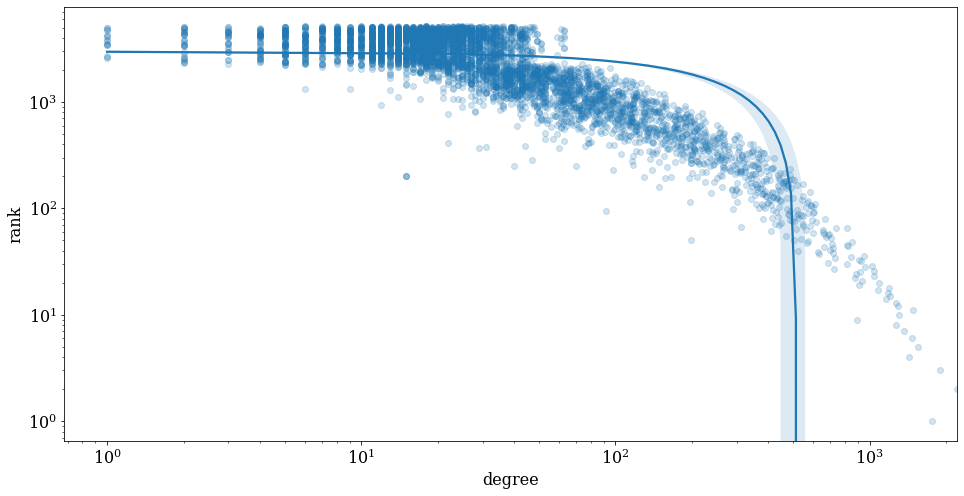

In [5]:
%%time

# Rank betweenness.
betweenness_ranking = centrality.sort_values(by = ['betweenness'], ascending = False).reset_index()
betweenness_ranking['rank'] = betweenness_ranking.index + 1

font = {'family': 'serif', 'weight': 'normal', 'size': 16}
plt.rc('font', **font)
plt.figure(figsize = (16, 8))

ax = sns.regplot(data = betweenness_ranking, 
                 x = 'degree', y = 'rank', scatter_kws = {'alpha': 0.2})

ax.set(xscale = 'log', yscale = 'log')

In [6]:
print (f'Rank Range: {betweenness_ranking["rank"].min()}–{betweenness_ranking["rank"].max()}')
betweenness_ranking.query('rank < 100').sort_values(by = ['degree'], ascending = True)

Rank Range: 1–5135


,index,source,betweenness,eigenvector,degree_cent,degree,rank
94,2751,lincoln-levi2,0.002331,0.010436,0.017920,92,95
49,531,boylston-ward,0.004827,0.011984,0.038761,199,50
97,60,adams-thomas,0.002280,0.023201,0.056291,289,98
66,3718,quincy-josiah2,0.003337,0.026149,0.060771,312,67
78,1823,giusta-antoine,0.002941,0.033567,0.073822,379,79
...,...,...,...,...,...,...,...
10,2370,jackson-andrew,0.020682,0.098674,0.289638,1487,11
4,568,brent-daniel,0.034387,0.094704,0.303078,1556,5
0,30,adams-george,0.074394,0.086603,0.342618,1759,1
2,4261,southard-samuel,0.050800,0.103207,0.368913,1894,3


CPU times: user 642 ms, sys: 6.72 ms, total: 649 ms
Wall time: 123 ms


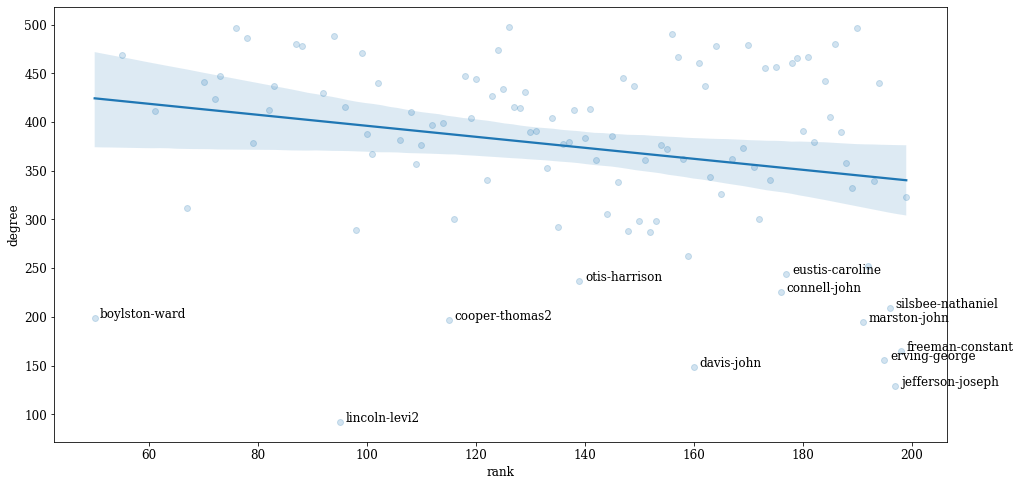

In [7]:
%%time

font = {'family': 'serif', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)
plt.figure(figsize = (16, 8))

between_sub = betweenness_ranking.query('(degree < 500) & (rank < 200)')

ax = sns.regplot(data = between_sub, x = 'rank', y = 'degree',
                 scatter_kws = {'alpha': 0.2})

# label points on the plot only if they are higher than the mean
for x, y, z in zip(between_sub['rank'], between_sub['degree'], between_sub['source']):
    if x < 200 and y < 250:
        plt.text(x = x + 1, # x-coordinate position of data label
                 y = y,
                 s = z, # data label
                 color = 'black') # set colour of line

## Degree Distribution

CPU times: user 16.2 ms, sys: 1.49 ms, total: 17.7 ms
Wall time: 16.7 ms


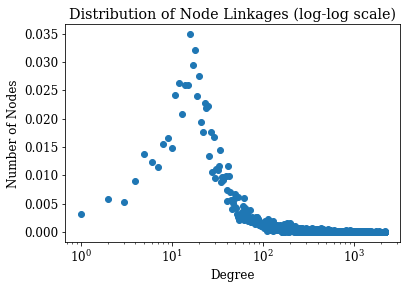

In [8]:
%%time

def plot_degree_histogram(g, normalized = True):
    aux_y = nx.degree_histogram(g)
    aux_x = np.arange(0, len(aux_y)).tolist()
    
    n_nodes = g.number_of_nodes()
    
    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i] / n_nodes
            
    return aux_x, aux_y

aux_x, aux_y = plot_degree_histogram(G)

# Plot
plt.title('Distribution of Node Linkages (log-log scale)')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')

plt.xscale('log')

plt.plot(aux_x, aux_y, 'o')

## Save Selected Ego Networks as Toy Datasets

### Boylston-Ward

In [45]:
l = [(1, 2), (3, 4), (5, 6)]

for i in l:
    if 3 in i:
        print (i)

(3, 4)


In [75]:
%%time

ego_name = 'boylston-ward'

ego = nx.ego_graph(G, ego_name, radius = 1)
print (nx.info(ego))

# Assign ego a color.
ego.nodes(data = True)[ego_name]['color'] = '#F2542D'

# Assign first-degree and second-degree from ego a color.
for e in ego.edges():
    if ego_name in e:
        
#         One-degree separation.
        if e[0] == ego_name:
            ego.nodes[e[1]]['color'] = '#F5DFBB'
            
        elif e[1] == ego_name:
            ego.nodes[e[0]]['color'] = '#F5DFBB'
            
#     Second-degree separation: if neither node is ego, assign color.
    else:
        ego.nodes[e[0]]['color'] = '#0E9594'
        ego.nodes[e[1]]['color'] = '#0E9594'
        
        
ego.nodes(data = True)['boylston-ward']

Name: 
Type: Graph
Number of nodes: 200
Number of edges: 3187
Average degree:  31.8700
CPU times: user 43.5 ms, sys: 1.7 ms, total: 45.2 ms
Wall time: 44.3 ms


{'degree': 199,
 'betweenness': 0.004827172725585329,
 'eigenvector': 0.011984250617060405,
 'modularity': 2,
 'degree_cent': 0.03876119984417608,
 'color': '#F2542D'}

In [76]:
%%time

# Serialize dictionary with json.
class NPEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)
    

ego = json_graph.node_link_data(ego) 
ego_json = json.dumps(ego, cls=NPEncoder)

with open(abs_dir + "Data/Output/Graphs/JQA_Network_correlation/ego-boylston-ward.json", "w") as f:
    f.write(ego_json)

CPU times: user 9.95 ms, sys: 1.02 ms, total: 11 ms
Wall time: 10.1 ms


### Lincoln-Levi2

In [77]:
%%time

ego_name = 'lincoln-levi2'

ego = nx.ego_graph(G, ego_name, radius = 1)
print (nx.info(ego))

# Assign ego a color.
ego.nodes(data = True)[ego_name]['color'] = '#F2542D'

# Assign first-degree and second-degree from ego a color.
for e in ego.edges():
    if ego_name in e:
        
#         One-degree separation.
        if e[0] == ego_name:
            ego.nodes[e[1]]['color'] = '#F5DFBB'
            
        elif e[1] == ego_name:
            ego.nodes[e[0]]['color'] = '#F5DFBB'
            
#     "Second-degree" separation: if neither node is ego, assign color.
#     As an ego node, all nodes connect to ego. These nodes also connect to other non-egos.
#     Order of operations could change color coding.
    else:
        ego.nodes[e[0]]['color'] = '#0E9594'
        ego.nodes[e[1]]['color'] = '#0E9594'
        
        
ego.nodes(data = True)['lincoln-levi2']

ego = json_graph.node_link_data(ego) 
ego_json = json.dumps(ego, cls=NPEncoder)

with open(abs_dir + "Data/Output/Graphs/JQA_Network_correlation/ego-lincoln-levi.json", "w") as f:
    f.write(ego_json)

Name: 
Type: Graph
Number of nodes: 93
Number of edges: 1874
Average degree:  40.3011
CPU times: user 35.9 ms, sys: 1.78 ms, total: 37.7 ms
Wall time: 36.7 ms


### Highest Ranked (least connected) Individual

In [33]:
%%time

betweenness_ranking.sort_values(by = ['rank'], ascending = False).head()

CPU times: user 1.51 ms, sys: 543 µs, total: 2.05 ms
Wall time: 1.54 ms


,index,source,betweenness,eigenvector,degree_cent,degree,rank
5134,0,Ishbosheth,0.0,0.002927,0.004675,24,5135
5133,3181,montgomery-john,0.0,0.000710,0.001363,7,5134
5132,1626,flint-jacob,0.0,0.000740,0.003506,18,5133
5131,1627,flint-james,0.0,0.000740,0.003506,18,5132
5130,234,bailey-unknown4,0.0,0.001094,0.002337,12,5131


In [36]:
%%time

ego = nx.ego_graph(G, 'Ishbosheth', radius = 1)
print(nx.info(ego))


ego = json_graph.node_link_data(ego) 
ego_json = json.dumps(ego, cls=NPEncoder)

with open(abs_dir + "Data/Output/Graphs/JQA_Network_correlation/ego-Ishbosheth.json", "w") as f:
    f.write(ego_json)

Name: 
Type: Graph
Number of nodes: 25
Number of edges: 300
Average degree:  24.0000
CPU times: user 8.96 ms, sys: 1.21 ms, total: 10.2 ms
Wall time: 9.52 ms
